In [37]:
import os
import numpy as np
from collections import OrderedDict, Counter

from PIL import Image
import torch
from torchvision import datasets
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn, optim
from efficientnet_pytorch import EfficientNet

Move the model to GPU, if available

In [12]:
use_cuda = torch.cuda.is_available()

# Specify Data Loaders

In [13]:
data_dir = "data"
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

## Specify appropriate transforms, and batch_sizes
data_transforms = {"train" :transforms.Compose([           
                           transforms.Resize((255,255)),            
                           transforms.CenterCrop(224),
                           transforms.RandomRotation((0, 359)),
                           transforms.RandomVerticalFlip(0.5),
                           transforms.ToTensor(),            
                           transforms.Normalize([0.485, 0.456, 0.406], 
                                                [0.229, 0.224, 0.225])]),                  

                   "valid" :transforms.Compose([transforms.Resize(255),
                             transforms.CenterCrop(224),                     
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406],
                                                  [0.229, 0.224, 0.225])]),

                    "test" : transforms.Compose([transforms.Resize(255),                        
                             transforms.CenterCrop(224),                     
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406],
                                                  [0.229, 0.224, 0.225])])}



# number of subprocesses to use for data loading
num_workers = 0

# how many samples per batch to load
# batch_size = 30

data_transfer = {"train" : datasets.ImageFolder(train_dir, transform = data_transforms["train"]),
                 "valid" : datasets.ImageFolder(valid_dir, transform = data_transforms["valid"]),
                 "test" : datasets.ImageFolder(test_dir, transform = data_transforms["test"])}

train_class_count = dict(Counter(data_transfer['train'].targets))
# valid_class_count = dict(Counter(data_transfer['valid'].targets))

# Imbalance set

In [32]:
dict(zip(data_transfer['train'].classes, list(train_class_count.values())))

{'melanoma': 374, 'nevus': 1372, 'seborrheic_keratosis': 254}

Inorder to overcome imbalance dataset, during training we pick more no. of samples from class1 & class3 using the function below

In [11]:
def ImbalancedDatasampler(count):
    samples_weights = torch.from_numpy(np.array([1/count[0]*3]*count[0] \   #assiging more weight to class1 since its our area of interest
                                                + [1/count[1]]*count[1] \
                                                + [1/count[2]]*count[2]))
    samples_weights = samples_weights.double()
    samplers = torch.utils.data.WeightedRandomSampler(samples_weights, len(samples_weights))
    return samplers

Sampler in train dataloader uses above function to load balanced samples from all three classes randomly in each iteration

In [14]:
# prepare data loaders
loaders = {"train" : torch.utils.data.DataLoader(data_transfer["train"], batch_size=64, 
                                                num_workers=num_workers,
                                                sampler = ImbalancedDatasampler(train_class_count)), 
            "valid" : torch.utils.data.DataLoader(data_transfer["valid"], batch_size=32, 
                                   num_workers=num_workers, shuffle=True),
            "test" : torch.utils.data.DataLoader(data_transfer["test"], batch_size=32, 
                                   num_workers=num_workers, shuffle=True)}

# Model - EfficientNet(V7)

In [35]:
# model_transfer = models.resnet50(pretrained=True)
model = EfficientNet.from_pretrained('efficientnet-b7')
# Freezing parameters of pretrained
for param in model.parameters():
    param.requires_grad = False

model._fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(2560, 512)),
                                      ('relu',nn.ReLU()),
                                      ('dropout',nn.Dropout(p=0.25)),
                                      ('fc2',nn.Linear(512,3))]))

# for param in model.fc.parameters():
#     param.requires_grad = True
    
if use_cuda:
    model = model.cuda()
print(model)

Loaded pretrained weights for efficientnet-b7
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        64, 16, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        16, 64, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2

# Specify Loss Function and Optimizer

In [7]:
### select loss function
criterion = nn.CrossEntropyLoss()

### select optimizer
optimizer = optim.SGD(model._fc.parameters(), lr=0.05)

# Train and Validate the Model

Let us train and validate the model in the code cell below and save the final model parameters at filepath 'model_parameters.pt'.

In [8]:
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf
n_epochs = 60
for epoch in range(1, n_epochs+1):
    # initialize variables to monitor training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        ## find the loss and update the model parameters accordingly
        output = model(data)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ## record the average training loss
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))


    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['valid']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        ## update the average validation loss
        valid_out = model(data)
        loss = criterion(valid_out, target)

        valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, 
        train_loss,
        valid_loss
        ))

    ## save the model if validation loss has decreased
    if valid_loss < valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). Saving Model...\n'.format(
                valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model_parameters.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.990232 	Validation Loss: 1.245262
Validation loss decreased (inf --> 1.245262). Saving Model...

Epoch: 2 	Training Loss: 0.943207 	Validation Loss: 1.263605
Epoch: 3 	Training Loss: 0.899412 	Validation Loss: 1.262310
Epoch: 4 	Training Loss: 0.878548 	Validation Loss: 1.248366
Epoch: 5 	Training Loss: 0.882426 	Validation Loss: 1.196392
Validation loss decreased (1.245262 --> 1.196392). Saving Model...

Epoch: 6 	Training Loss: 0.841792 	Validation Loss: 1.186013
Validation loss decreased (1.196392 --> 1.186013). Saving Model...

Epoch: 7 	Training Loss: 0.807332 	Validation Loss: 1.162100
Validation loss decreased (1.186013 --> 1.162100). Saving Model...

Epoch: 8 	Training Loss: 0.788640 	Validation Loss: 1.148106
Validation loss decreased (1.162100 --> 1.148106). Saving Model...

Epoch: 9 	Training Loss: 0.773589 	Validation Loss: 1.124693
Validation loss decreased (1.148106 --> 1.124693). Saving Model...

Epoch: 10 	Training Loss: 0.782260 	Validation L

Load the model that got the best validation accuracy

In [36]:
model.load_state_dict(torch.load('model_parameters.pt'))

<All keys matched successfully>

# Get Prediction Probability for Class1 & Class3

Code module below stores the prediction probability in CSV which is given as an input to get_results.py to get output scores and ROC curve.

In [10]:
# from PIL import Image
# from glob import glob
# import pandas as pd
# import torch.nn.functional as nnf

# # load filenames for human and dog images
# img_path = np.array(glob(r"data\test\*\*"))

# df = pd.DataFrame(index = range(len(img_path)), columns = ["Id","task_1","task_2"])

# for i in range(len(img_path)):
#     img = Image.open(img_path[i]).convert('RGB')
#     image = data_transforms['test'](img).reshape(1,3,224,224)
#     image = image.cuda()
#     output = model(image)
#     output = nnf.softmax(output, dim=1).data[0]
#     prob = output.cpu().detach().numpy()
#     df.loc[i,"Id"] = img_path[i]
#     df.loc[i,"task_1"] = prob[0]
#     df.loc[i,"task_2"] = prob[2]
#     if i%50 == 0:
#         print(i)

# df.to_csv('sample_predictions.csv', index = False)

Alternatively, we plot the ROC curve and print scores for prediction probability in the modules below

In [15]:
def load_image(path):
  image = Image.open(path)
  image = data_transforms['test'](image)
  image = torch.tensor(image, requires_grad=True)
  image = image.unsqueeze(0)
  return image

In [16]:
def get_predictions(img_paths):
  """ Is melanoma? """
  pred_rank1 = [] # Is melanoma?
  pred_rank2 = [] # Is seborrheic?
  for img_path in img_paths:
    img = load_image(img_path)
    #img.to(device)
    prediction = model(img)
    #img.to("cpu")
    pred_rank1.append(float(prediction.data[0][0]))
    pred_rank2.append(float(prediction.data[0][2]))
  return pred_rank1, pred_rank2

model.to("cpu")
model.eval()

In [17]:
img_paths = np.array(glob(r"data\test\*\*"))
task1, task2 = get_predictions(img_paths)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [18]:
import csv

with open('results.csv', 'w', newline='') as csvfile:
  doc = csv.writer(csvfile)
  doc.writerow(['Id', 'task_1', 'task_2'])
  for i in range(len(img_paths)):
    doc.writerow([img_paths[i], task1[i], task2[i]])

# Get Scores

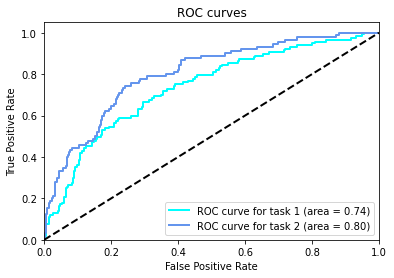

Category 1 Score: 0.735
Category 2 Score: 0.801
Category 3 Score: 0.768


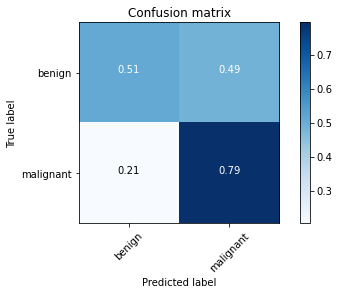

In [19]:
import pandas as pd
import sys
import itertools
import get_results as results

threshold = 0.5 

# get ground truth labels for test dataset
truth = pd.read_csv('ground_truth.csv')
y_true = truth[["task_1","task_2"]].values

# get model predictions for test dataset
y_pred = pd.read_csv('results.csv')
y_pred = y_pred[["task_1","task_2"]].values

# plot ROC curves and print scores
results.plot_roc_auc(y_true, y_pred)
# plot confusion matrix
classes = ['benign', 'malignant']
results.plot_confusion_matrix(y_true[:,0], y_pred[:,0], threshold, classes)